### Imports

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
df = cifar10.load_data()

In [3]:
import cv2
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, RandomFlip, RandomRotation, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import pandas as pd
import os
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline

### Load Data


Use the gdown code below to load this folder into your notebook:

 Following code cell loads images into arrays
 After running this cell you get :

    X -> Image array to be used for plotting
    X_processed -> Image array to be used for feeding to model
    y -> Labels encoded a/c to scheme in class_map
    class_map -> maps dog_breed to number
    inv_class_map -> maps number to dog_breed

In [4]:
# Utils
data_path = './SOTA_Lab_Dataset'

def load_image(image_path):
    """
    This function loads an img from given path
    """
    img = cv2.imread(image_path)
    assert img is not None, f"Image at path {image_path} is empty or None."
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Load images
X, y = [], []
for dog_breed in os.listdir(data_path):
    if '-' in dog_breed:
        breed = dog_breed.split('-')[1]
        for img_name in os.listdir(os.path.join(data_path, dog_breed)):
            img_path = os.path.join(data_path, dog_breed, img_name)
            if os.path.isfile(img_path):
                img = load_image(img_path)
                X.append(img)
                y.append(breed)
    else:
        print(f"Skipping directory {dog_breed}, does not contain '-'")
# Dictionary to map breed to number
class_map = {breed : i for i, breed in enumerate(set(y))}
class_map_inv = {b : a for a, b in class_map.items()}

X = np.array(X)
y = np.array([class_map[breed] for breed in y])

# shuffling data
index = [*range(len(y))]
np.random.shuffle(index)
# X is for plotting
X = X[index]
# X_processed is for model
X_processed = np.array([preprocess_input(x) for x in X])
y = y[index]

print(X.shape)
print(X_processed.shape)
print(y.shape)

(2476, 224, 224, 3)
(2476, 224, 224, 3)
(2476,)


### Compute Image Similarities

In [8]:
# Load the MobileNetV2 model pre-trained on ImageNet, excluding the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a model that outputs embeddings
model = Model(inputs=base_model.input, outputs=base_model.output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# Generate embeddings for all images
embeddings = model.predict(X_processed)
embeddings = embeddings.reshape(embeddings.shape[0], -1)  # Flatten the embeddings if needed
print(f'Embeddings shape: {embeddings.shape}')

78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 380ms/step
Embeddings shape: (2476, 62720)


In [13]:
# Function to get top N most similar images
def get_top_n_similar(embeddings, query_embedding, n=5):
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    top_n_indices = similarities.argsort()[-n:][::-1]  # Get indices of top N similar images
    return top_n_indices, similarities[top_n_indices]

# Query a random image
query_index = np.random.randint(len(X))
query_image = X[query_index]
query_embedding = embeddings[query_index]

# Get top 5 most similar images
top_n_indices, similarities = get_top_n_similar(embeddings, query_embedding, n=5)

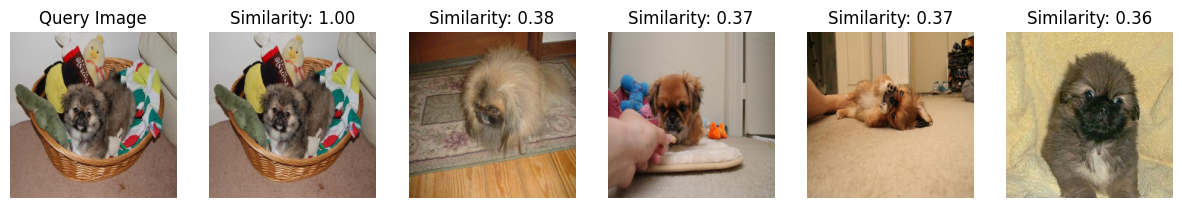

In [14]:
def plot_similar_images(query_image, similar_images, similarities):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    
    for i, (img, sim) in enumerate(zip(similar_images, similarities), 2):
        plt.subplot(1, len(similar_images) + 1, i)
        plt.imshow(img)
        plt.title(f"Similarity: {sim:.2f}")
        plt.axis('off')
    
    plt.show()

# Get similar images
similar_images = [X[i] for i in top_n_indices]

# Plot query image and most similar images
plot_similar_images(query_image, similar_images, similarities)

### Fine-Tuning Classification Model

In [9]:
# Your code here


